In [2]:
# #Astropy
# import astropy
# from astropy.io import fits
# from astropy.table import Table

# # Dlnpyutils
# from dlnpyutils import utils

# # Matplotlib
# import matplotlib
# import matplotlib.pyplot as plt
# # %matplotlib inline
# matplotlib.rcParams.update({'font.size': 25})

# #Numpy/Scipy
# import numpy as np
# import scipy
# from scipy.interpolate import interp1d
# from scipy.optimize import curve_fit

In [ ]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Dlnpyutils
from dlnpyutils import utils

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

class Aetas():
    '''
    A class to calculate a star's extinction, age and mass using PARSEC isochrones with 
    Gaia and 2MASS photometry.
    '''
    def __init__(self,teff,logg,abund,obsphot,distance,isochrones):
        
        '''
        Inputs:
        ------
            teff:       2x1 array-like
                        Teff and error of star np.array([teff,teff_err])
            
            logg:       3x1 array-like
                        logg, cal logg, logg err
                    
            abund:      2x1 array-like
                        first column is [M/H] and [Alpha/M] and the second column is the errors
                    
            obs_phot:   6x2 array-like
                        first column is BP,G,RP,J,H and K and the second column is the errors
                        
            distance:   float
                        distance to star in pc
                    
            isochrones: astropy Table 
                        PARSEC isochrone table

        '''
        
        # Teff and log(g)
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        self.logg = logg[0] # log(g)
        self.logg_cal = logg[1] # calibrated log(g)
        self.logg_err = logg[2] # log(g) error
        
        # Salaris [Fe/H] Asplund 2021 et al.
        self.salfeh = abund[0,0]+np.log10(0.659*(10**(abund[1,0]))+0.341) # Salaris Corrected [Fe/H]
        self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.341/(0.659*(10**(abund[1,0]))+0.341))*abund[1,1])**2)
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # Absolute Magnitudes Not Derreddened
        self.absphot = self.phot-self.distmod
        
        # PARSEC isochrones
        self.labels = ['G_BPEDR3mag','GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']
        
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        self.uniq_ages = np.unique(self.iso['logAge'])
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPEDR3mag':0.5387,'GEDR3mag':0.6419,'G_RPEDR3mag':0.7667,
                     'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
        
    #################
    ### Utilities ###
    #################
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value

        Inputs:
        ------
            data:  array-like
                   data to search through

            value: float or int
                   value of interest

        Output:
        ------
            close: float or int
                   value in data closest to given value
        '''
        
        data = np.asarray(data)
    
#         data = data[np.where(np.isfinite(data)==True)]
        
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value

        Inputs:
        ------
            data:   array-like
                    data to search through

            value:  float or int
                    value of interest

        Output:
        ------
            close1: float or int
                    closest value under the given value

            close2: float or int
                    closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def mad(self,data,normal=False):
        '''
        Calculate the median absolute deviation of the data

        Inputs:
        ------
            data:   array-like
                    data to calculate the median absolute deviation of

            normal: True or False
                    if True the MAD will be scaled to the normal distribution

        Output:
        ------
            mad:    float
                    median absolute deviation in the data
        '''

        if normal == True:
            mad = np.nanmedian(np.abs(data-np.nanmedian(data)))/scipy.stats.norm.ppf(0.75)
            return mad

        mad = np.nanmedian(np.abs(data-np.nanmedian(data)))
        return mad
    
    ##################
    ### Extinction ###
    ##################
    
    def ccm_a(self,x):
        '''
        a(x) function from CCM et al. 1989

        Input:
        -----
            x: float
               effective wavelength in units of 1/micron

        Output:
        ------
            a: float
               value of the "a" function from CCM et al. 89  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def ccm_b(self,x):
        '''
        b(x) function from ccm et al. 1989

        Input:
        -----
            x: float
               effective wavelength in units of 1/micron

        Output:
        ------
            b: float
               value of the "b" function from CCM et al. 89 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def ccm_alav(self,wave):
        '''
        Calculate the relative extinction of one band to the V band using
        Cardelli et al. 1989 (A\lambda/Av)

        Inputs:
        ------
            wave: float
                  effective wavelength in units of micron

            rv:   float
                  Rv Slope of the extinction law (= Av/E(B-V))

        Output:
        ------
            alav: float
                  A\lambda/Av
        '''
        x=1/wave
        alav = self.ccm_a(x)+self.ccm_b(x)/3.1
        return alav
    
    def fitz_alebv(self,wave):
        '''
        Calculate the relative extinction to E(B-V) using Fitzpatrick 1999 extinction law
        '''
        recip_anchors = np.array([0.000,0.377,0.820,1.667,1.828,2.141,2.433,3.704,3.846])
        alebv_anchors = np.array([0.000,0.265,0.829,2.688,3.055,3.806,4.315,6.265,6.591])
        
        x=1/wave
        spl = interp1d(recip_anchors,alebv_anchors)
        alebv = spl(x)
        return alebv
    
    def extinction(self,law='cardelli'):
        '''
        Calulate the extinctions for the BP, G, RP, J, H, and K bands
        
        Input:
        -----
            law: str
                 the extinction law used ('cardelli' or 'fitzpatrick')
        
        Output:
        ------
            ext: 6x2 array
                 first column is the extinction values and the second is the errors
            
        '''
        
        # isochrone magnitude labels
        color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
                                 ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
        
        # pick isochrone points with temperatures within 200 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
                           (self.iso['logTe']>np.log10(self.teff-200.)))
        iso_ = self.iso[teffcut]
    
        # get colors and errors
        obs_colors = np.delete(self.phot[:]-self.phot[1],1)
        obs_colors[1:] = -1*obs_colors[1:]
        obs_colors_err = np.delete(np.sqrt(self.phot_err[:]**2+self.phot_err[1]**2),1)
        
        # create "reddening" vector (slightly modified from the normal definition)
        if law == 'Cardelli':
            red_vec = np.array([self.fitz_alebv(self.leff['G_BPEDR3mag'])/self.fitz_alebv(self.leff['GEDR3mag'])-1.,
                               1.-self.fitz_alebv(self.leff['G_RPEDR3mag'])/self.fitz_alebv(self.leff['GEDR3mag']),
                               1.-self.fitz_alebv(self.leff['Jmag'])/self.fitz_alebv(self.leff['GEDR3mag']),
                               1.-self.fitz_alebv(self.leff['Hmag'])/self.fitz_alebv(self.leff['GEDR3mag']),
                               1.-self.fitz_alebv(self.leff['Ksmag'])/self.fitz_alebv(self.leff['GEDR3mag'])])
            
            ext_vec = np.array([self.fitz_alebv(self.leff['G_BPEDR3mag'])/self.fitz_alebv(self.leff['GEDR3mag']),1.,
                               self.fitz_alebv(self.leff['G_RPEDR3mag'])/self.fitz_alebv(self.leff['GEDR3mag']),
                               self.fitz_alebv(self.leff['Jmag'])/self.fitz_alebv(self.leff['GEDR3mag']),
                               self.fitz_alebv(self.leff['Hmag'])/self.fitz_alebv(self.leff['GEDR3mag']),
                               self.fitz_alebv(self.leff['Ksmag'])/self.fitz_alebv(self.leff['GEDR3mag'])])
            
        else:
            red_vec = np.array([self.ccm_alav(self.leff['G_BPEDR3mag'])/self.ccm_alav(self.leff['GEDR3mag'])-1.,
                               1.-self.ccm_alav(self.leff['G_RPEDR3mag'])/self.ccm_alav(self.leff['GEDR3mag']),
                               1.-self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['GEDR3mag']),
                               1.-self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['GEDR3mag']),
                               1.-self.ccm_alav(self.leff['Ksmag'])/self.ccm_alav(self.leff['GEDR3mag'])])
            
            ext_vec = np.array([self.ccm_alav(self.leff['G_BPEDR3mag'])/self.ccm_alav(self.leff['GEDR3mag']),1.,
                               self.ccm_alav(self.leff['G_RPEDR3mag'])/self.ccm_alav(self.leff['GEDR3mag']),
                               self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['GEDR3mag']),
                               self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['GEDR3mag']),
                               self.ccm_alav(self.leff['Ksmag'])/self.ccm_alav(self.leff['GEDR3mag'])])
        
        # calculate the intrinsic colors using a b-spline
        b_vec = 999999.0*np.ones(5)
        b_vec_deriv = 999999.0*np.ones(5)
        
        for i in range(5):
#             try:
            # Interpolate the color-Teff relation using a b-spline
            color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])
            logTe = iso_['logTe']

            bspl = utils.bspline(logTe,color)
            b_vec[i] = bspl(np.log10(self.teff))
            b_vec_deriv[i] = bspl.derivative()(np.log10(self.teff))
                
#             except:
#                 b_vec[i] = 999999.0
#                 b_vec_deriv[i] = 999999.0
                
        # calculate the extinctions and errors
        color_diff = obs_colors-b_vec
        
        print(color_diff)
        
        ag = np.dot(red_vec,color_diff)/np.linalg.norm(red_vec)**2
        ag_err = np.dot(red_vec,obs_colors_err)/np.linalg.norm(red_vec)**2
        
        ext = 999999.0*np.ones((6,2))
        ext[:,0] = ext_vec*ag
        ext[:,1] = ext_vec*ag_err
        
        self.ext = ext
        
        return ext
    

# Extra Functions

In [3]:
from tqdm import tqdm_notebook

leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def fitz_alebv(wave):
    '''
    Fitzpatrick 1999 extinction law
    '''
    recip_anchors = np.array([0.000,0.377,0.820,1.667,1.828,2.141,2.433,3.704,3.846])#[:-2]
    alebv_anchors = np.array([0.000,0.265,0.829,2.688,3.055,3.806,4.315,6.265,6.591])#[:-2]

    x=1/wave
    spl = interp1d(recip_anchors,alebv_anchors)
    alebv = spl(x)
    return alebv

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
#     data = data[np.where(np.isfinite(data)==True)]
    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

def mass_2_age_PARSEC(mass,salfeh,isochrones):
    '''
    Inputs:
    ------
        mass: star mass in Msun
        salfeh: Salaris corrected [Fe/H]
        isochrones: table of PARSEC isochrones
    
    Output:
    ------
        age: age in Gyr
    '''
    
    feh_lo,feh_hi = neighbors(isochrones['MH'],salfeh)
    
    iso_lo = isochrones[np.where(isochrones['MH']==feh_lo)]
    iso_hi = isochrones[np.where(isochrones['MH']==feh_hi)]
    
    try:
        # lower [Fe/H]
        sidx_lo = np.argsort(iso_lo['Mass'])
        smass_lo = iso_lo['Mass'][sidx_lo]
        _,uidx_lo = np.unique(smass_lo,return_index=True)
        smass_lo = smass_lo[uidx_lo]
        sage_lo = 10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9

        spl_lo = interp1d(smass_lo,sage_lo)

        # higher [Fe/H]
        sidx_hi = np.argsort(iso_hi['Mass'])
        smass_hi = iso_hi['Mass'][sidx_hi]
        _,uidx_hi = np.unique(smass_hi,return_index=True)
        smass_hi = smass_hi[uidx_hi]
        sage_hi = 10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9

        spl_hi = interp1d(smass_hi,sage_hi)

        # final spline
        final_spl = interp1d([feh_lo,feh_hi],[spl_lo(mass),spl_hi(mass)])
        age = final_spl(salfeh)
        return age
    except:
        return 999999.0

# PARSEC

In [4]:
# massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
# massive = massive['index','MH','Mass','logAge','logTe','logg','X','Xc','Xn','Xo','Y','Z',
#                   'Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

massive = massive['MH','Mass','logAge','logTe','logg','GEDR3mag','G_BPEDR3mag','G_RPEDR3mag',
                  'Jmag','Hmag','Ksmag']

# APOKASC 

<ipython-input-5-4b095068ff9b>:5: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)


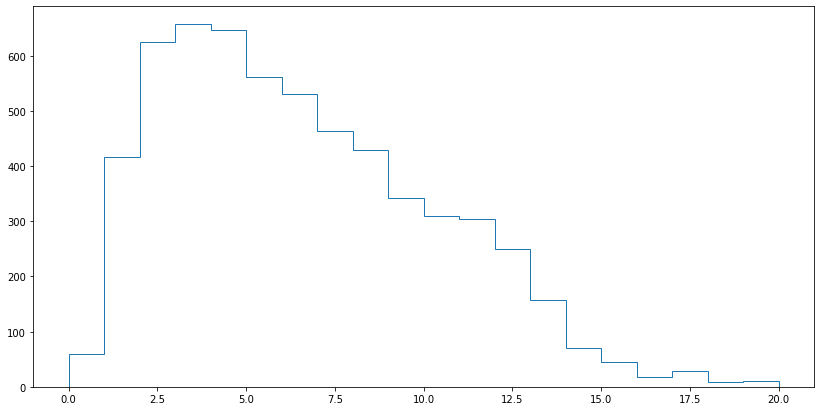

In [5]:
# dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec_rev1.fits.gz')
# dr16 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r12-l33.fits.gz')
apoafe = dr17['ALPHA_M']+dr17['M_H']-dr17['FE_H']
apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = dr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(dr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

k674 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.4.fits.gz')

# xmatch APOKASC with DR17
_, k674idx, dr17idx = np.intersect1d(k674['2MASS_ID'],dr17['APOGEE_ID'],return_indices=True)

k674 = k674[k674idx]
kdr17 = dr17[dr17idx]
salfeh = salfeh[dr17idx]
salfeh_err = salfeh_err[dr17idx]

# Select RGB stars
ageevs = np.where((k674['A3P_AGEMOD_JT']>-10.)&(k674['APOKASC3_CONS_EVSTATES']==1.0)&
                  (np.isfinite(kdr17['FE_H'])==True))

k674 = k674[ageevs]
kdr17 = kdr17[ageevs]
salfeh = salfeh[ageevs]
salfeh_err = salfeh_err[ageevs]

plt.figure(figsize=[14,7])
plt.hist(k674['A3P_AGEMOD_JT'],histtype='step',range=(0,20),bins=20)
plt.show()

In [9]:
parsec_age = 999999.0*np.ones(len(kdr17))

for i in tqdm_notebook(range(len(kdr17))):
    parsec_age[i] = mass_2_age_PARSEC(k674['APOKASC3P_MASS'][i],salfeh[i],massive)

<ipython-input-9-aa93cd7ae93e>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(kdr17))):


  0%|          | 0/6099 [00:00<?, ?it/s]

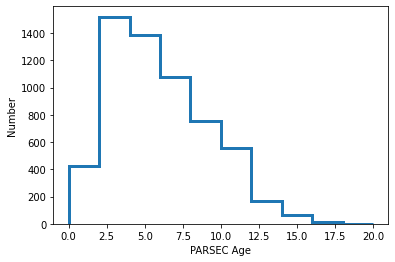

In [10]:
plt.hist(parsec_age,histtype='step',lw=3.0,range=(0,20));
plt.xlabel(r'PARSEC Age')
plt.ylabel(r'Number')
plt.show()

# Gaia EDR3

In [7]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

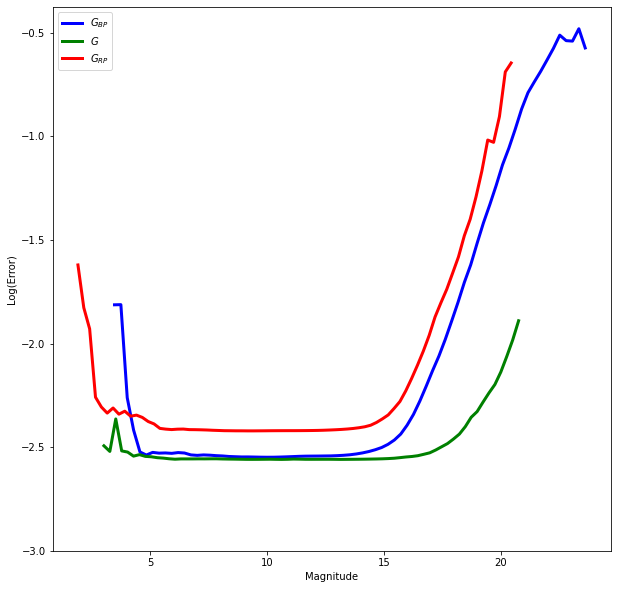

In [8]:
from scipy.stats import binned_statistic, binned_statistic_2d

binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

bperrfunc = utils.bspline(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
gerrfunc = utils.bspline(np.arange(gmin,gmax,gdiff/binnum),gbin)
rperrfunc = utils.bspline(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(kdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

In [ ]:
def extinction(teff,phot,feh,isochrones,law='cardelli'):
    '''
    Calulate the extinctions for the BP, G, RP, J, H, and K bands

    Input:
    -----
        teff: 2x1 array
              temperature of a star
        
        phot: 6x2 array
              photometry of a star in BP, G, RP, J, H, K
              
        feh:  2x1 array
              Metallicity of star (ideally Salaris corrected)
              
        isochrones: Table
                    PARSEC isochrones
        
        law: str
             the extinction law used ('cardelli' or 'fitzpatrick')

    Output:
    ------
        ext: 6x2 array
             first column is the extinction values and the second is the errors

    '''

    # isochrone magnitude labels
    color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
                             ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T

    # pick isochrone points with temperatures within 200 K of the star's Teff
    teffcut = np.where((isochrones['logTe']<np.log10(teff+200.))&
                       (isochrones['logTe']>np.log10(teff-200.))&
                       (isochrones['MH']==closest(isochrones['MH'],feh)))
    
    # check to make sure teff of star is in range of the isochrone
    if np.size(np.squeeze(teffcut))==0:
#         self.ext = 999999.0*np.ones((6,2))
        return 999999.0*np.ones((6,2))
        
    iso_ = isochrones[teffcut]

    # get colors and errors
    obs_colors = np.delete(phot-phot[1],1)
    obs_colors[1:] = -1*obs_colors[1:]
    obs_colors_err = np.delete(np.sqrt(phot_err**2+phot_err[1]**2),1)

    # create "reddening" vector (slightly modified from the normal definition)
    if law == 'Cardelli':
        red_vec = np.array([fitz_alebv(leff['G_BPEDR3mag'])/fitz_alebv(leff['GEDR3mag'])-1.,
                           1.-fitz_alebv(leff['G_RPEDR3mag'])/fitz_alebv(leff['GEDR3mag']),
                           1.-fitz_alebv(leff['Jmag'])/fitz_alebv(leff['GEDR3mag']),
                           1.-fitz_alebv(leff['Hmag'])/fitz_alebv(leff['GEDR3mag']),
                           1.-fitz_alebv(leff['Ksmag'])/fitz_alebv(leff['GEDR3mag'])])

        ext_vec = np.array([fitz_alebv(leff['G_BPEDR3mag'])/fitz_alebv(leff['GEDR3mag']),1.,
                           fitz_alebv(leff['G_RPEDR3mag'])/fitz_alebv(leff['GEDR3mag']),
                           fitz_alebv(leff['Jmag'])/fitz_alebv(leff['GEDR3mag']),
                           fitz_alebv(leff['Hmag'])/fitz_alebv(leff['GEDR3mag']),
                           fitz_alebv(leff['Ksmag'])/fitz_alebv(leff['GEDR3mag'])])

    else:
        red_vec = np.array([ccm_alav(leff['G_BPEDR3mag'])/ccm_alav(leff['GEDR3mag'])-1.,
                           1.-ccm_alav(leff['G_RPEDR3mag'])/ccm_alav(leff['GEDR3mag']),
                           1.-ccm_alav(leff['Jmag'])/ccm_alav(leff['GEDR3mag']),
                           1.-ccm_alav(leff['Hmag'])/ccm_alav(leff['GEDR3mag']),
                           1.-ccm_alav(leff['Ksmag'])/ccm_alav(leff['GEDR3mag'])])

        ext_vec = np.array([ccm_alav(leff['G_BPEDR3mag'])/ccm_alav(leff['GEDR3mag']),1.,
                           ccm_alav(leff['G_RPEDR3mag'])/ccm_alav(leff['GEDR3mag']),
                           ccm_alav(leff['Jmag'])/ccm_alav(leff['GEDR3mag']),
                           ccm_alav(leff['Hmag'])/ccm_alav(leff['GEDR3mag']),
                           ccm_alav(leff['Ksmag'])/ccm_alav(leff['GEDR3mag'])])

    # calculate the intrinsic colors using a b-spline
    b_vec = 999999.0*np.ones(5)
    b_vec_deriv = 999999.0*np.ones(5)

    for i in range(5):
            try:
                # Interpolate the color-Teff relation using a b-spline
                color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])
                logTe = iso_['logTe']

                bspl = utils.bspline(logTe,color)
                b_vec[i] = bspl(np.log10(teff))
                b_vec_deriv[i] = bspl.derivative()(np.log10(teff))

            except:
                b_vec[i] = 999999.0
                b_vec_deriv[i] = 999999.0

    # calculate the extinctions and errors
    color_diff = obs_colors-b_vec
    
    neg_cut = np.where(color_diff>0)
    
    # 
    if np.size(np.squeeze(neg_cut))==0:
#         self.ext = 999999.0*np.ones((6,2))
        return 999999.0*np.ones((6,2))

    ag = np.dot(red_vec[neg_cut],color_diff[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
    ag_err = np.dot(red_vec[neg_cut],obs_colors_err[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2

    ext = 999999.0*np.ones((6,2))
    ext[:,0] = ext_vec*ag
    ext[:,1] = ext_vec*ag_err

#     self.ext = ext

    return ext

In [11]:
color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
                             ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
for i in range(5):
    print(color_labels[i,0]+'-'+color_labels[i,1])

G_BPEDR3mag-GEDR3mag
GEDR3mag-G_RPEDR3mag
GEDR3mag-Jmag
GEDR3mag-Hmag
GEDR3mag-Ksmag


In [15]:
phot = np.array(['G_BPEDR3mag','GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag'])
print(phot[:]+'-'+phot[1])
print(obs)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U11'), dtype('<U1')) -> None

In [24]:
for i in range(5):
    print(phot[i]+'-'+phot[1])

G_BPEDR3mag-GEDR3mag
GEDR3mag-GEDR3mag
G_RPEDR3mag-GEDR3mag
Jmag-GEDR3mag
Hmag-GEDR3mag


In [33]:
phot_err = np.array([4,3,2,1])
np.delete(np.sqrt(phot_err**2+phot_err[1]**2),1)

array([5.        , 3.60555128, 3.16227766])

In [34]:
np.sqrt(phot_err**2+phot_err[1]**2)

array([5.        , 4.24264069, 3.60555128, 3.16227766])

In [38]:
np.sqrt(phot_err**2+9)

array([5.        , 4.24264069, 3.60555128, 3.16227766])